# Quick start with the Rosbank dataset as an example

This notebook is to show how to use <b>the DUE model</b> combining fully contected ResNet and Gaussian process in order to make predictions based on dataset consisting of embeddings provided by <i>the PCA method</i>. <br>
The embeddings correspond to features of clients from the <b>Rosbank</b> dataset. The features are obtained by aggregation of transaction history of each client.  <br>
The embeddings and targets are stored in separate files with `.parquet` extension.  

The main parts of the notebook are following:
* Classifier initialization using configuration files.

* Splitting the original dataset on train and validation parts. Training the model on the train dataset and check metrics on the validation dataset.

* Filtration the original dataset using <i> the forgetting method</i>.
    - Search examples with noisy labels by <i> the forgetting method </i>. At this step the model is trained on overall examples of the dataset to compute forgetting statistics of each example during training. This statistics allow one to calculate a number of epochs in which each example of dataset was forgotten. If an example is unlearned during the training procedure its forgetting counts are equal to the total number of epochs. The unlearned examples are excluded from the dataset, as it is assumed that among the unlearned examples there are a lot of examples with incorrect labels. 
    - Splitting the dataset with excluded examples on train and validation parts. Training the model and check metrics.<br>
<br>
* Filtration the original dataset using <i>the second-split forgetting method</i>.
    - Search examples with noisy labels by <i>the second-split forgetting method</i>. In this method the original dataset is splitted into two parts.
    Initially the model is trained based on examples from the first part. Then the train of the model is continued using examples from the second part. The examples, which after the first epoch on the second step are forgotten forever, are proposed to be excluded from the second part. The same procedure is repeated in reverse order to find noisy examples in the first part of the dataset.
    - Splitting the dataset with excluded examples on train and validation parts. Training the model and check metrics.<br>
<br>
* Predicting labels of examples using model loaded from a `.ckpt` file.  

### Import necessary libraries

Main class for creation the classifier is `DueClassifier`. The object of this class contain all necessary methods to train the Due model and obtain name of files for excluding.

In [2]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

from prcskr.filtration_classification.main import FilteredClassifier

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Classifier initialization

All parameters to initialize the Due model and training procedure are given by `.yml` configs files. <i>The data configuration file</i> contains information for initialization PyTorch dataloader. <i>The model configuration file</i> contains parameters for initialziation the Due Model, and also some parameters of the training procedure. <br> 

Logs of the training procedure are collected in a `log_dir` directory. <br>
Checkpoints obtained during the training are collected in a `ckpt_dir`. Only checkpoints corresponding at the current epoch and the epoch with best metrics for the validation dataset (or the training dataset if the validation dataset is absent) are saved.

In [3]:
log_dir = '../data/rosbank/logs'
ckpt_dir = '../data/rosbank/ckpts'

path_to_dataconf = '../srcprcskr/configs/data/data_config_rosbank_demonstration.yml'
path_to_modelconf = '../srcprcskr/configs/models/model_config_rosbank_demonstration.yml'

run_name = 'rosbank_notebook'

classifier = FilteredClassifier(
    run_name = run_name,
    log_dir=log_dir, 
    ckpt_dir=ckpt_dir,
    path_to_dataconf=path_to_dataconf,
    path_to_modelconf=path_to_modelconf
)

### 2. Train the model on the original dataset

To train the model, the method `fit` is used. The path to the dataset is given by `data_filepath` argument. The argument `split_frac_train_val` determines the fraction of the train part from the original dataset. If `split_frac_train_val` is equal 1.0, only train dataset is used. 

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'
split_frac_train_val = 0.9

classifier.fit(
    features_path=features_path,
    targets_path=targets_path,
    split_frac_train_val=split_frac_train_val
)

```
Metrics for the validation dataset:
{'acc_score': 0.68, 'recall_score': 0.4502923976608187, 'roc_auc_score': 0.6426879624389528, 'pr_auc_score': 0.5728869482061277}
```

In [4]:
features_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_targets.parquet'
ckpt_resume = '../data/rosbank/ckpts/rosbank_notebook_fit/epoch: 0048 - acc_score: 0.6711 - recall_score: 0.5029 - roc_auc_score: 0.6663 - pr_auc_score: 0.6135 - loss: 0.6122.ckpt'
preds_proba, uncertainties, file_names, true_labels = classifier.predict(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10


100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


In [5]:
preds_labels = np.argmax(preds_proba, axis=1)
preds_proba_pos = np.max(preds_proba, axis=1)

acc_eval = accuracy_score(true_labels, preds_labels)
recall_eval = recall_score(true_labels, preds_labels)
rocauc_eval = roc_auc_score(true_labels, preds_proba_pos)

precision_eval, recall_evall, _ = precision_recall_curve(true_labels, preds_proba_pos)
pr_recall_auc = auc(recall_evall, precision_eval)

print(f'acc: {acc_eval:.3f}, recall: {recall_eval:.3f}, roc_auc: {rocauc_eval:.3f}, precision_recall {pr_recall_auc:.3f}')

acc: 0.694, recall: 0.713, roc_auc: 0.669, precision_recall 0.778


As the predictions of the Due model are determined by the Monte-Carlo method, new predictions of the model are slightly changed.

In [4]:
features_path = '/home/storage/priceseekers/data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '/home/storage/priceseekers/data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'
ckpt_resume = '/home/storage/projects/sber_project_priceseekers/ckpt_due_rosbank_example/rosbank_notebook_fit/epoch: 0120 - acc_score: 0.6755 - roc_auc_score: 0.6676 - loss: 0.5373.ckpt'
split_frac_train_val = 0.8
classifier.fit(
    features_path=features_path,
    targets_path=targets_path,
    split_frac_train_val=split_frac_train_val,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10
total epochs is specified from config as 120
lr is specified from config as 0.001
Checkpoint for the last epoch: /home/storage/projects/sber_project_priceseekers/ckpt_due_rosbank_example/rosbank_notebook_fit/epoch: 0120 - acc_score: 0.6755 - roc_auc_score: 0.6676 - loss: 0.5373.ckpt
/home/storage/projects/sber_project_priceseekers/ckpt_due_rosbank_example/rosbank_notebook_fit/epoch: 0120 - acc_score: 0.6755 - roc_auc_score: 0.6676 - loss: 0.5373.ckpt


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

Metrics for the validation dataset:
{'acc_score': 0.6772046589018302, 'roc_auc_score': 0.6696227929373997}


### 3. Filtration the dataset through the forgetting method

#### 3.1 Search the examples for excluding

To find the noisy examples by computing forgetting statistics during training of the model, the `filtration_by_forgetting` method is proposed. <br>
As a result, the array of file names for excluding is saved in a `.txt` file. Further this file can be used to exclude examples from the original dataset for training the model. Also, the method returns `pd.DataFrame`, which contains forgetting counts for each examples, as well as the predictions given by the trained model.

In [ ]:
log_dir = '../data/rosbank/logs'
ckpt_dir = '../data/rosbank/ckpts'

path_to_dataconf = '../srcprcskr/configs/data/data_config_rosbank_demonstration.yml'
path_to_modelconf = '../srcprcskr/configs/models/model_config_rosbank_demonstration.yml'

run_name = 'rosbank_notebook'

classifier = FilteredClassifier(
    run_name = run_name,
    log_dir=log_dir, 
    ckpt_dir=ckpt_dir,
    path_to_dataconf=path_to_dataconf,
    path_to_modelconf=path_to_modelconf
)

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'

df_examples_forgetting_info = classifier.filtration_by_forgetting(
    features_path=features_path,
    targets_path=targets_path,
)

```
Number of examples to exclude: 80
Examples forgetting stats are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_forgetting/rosbank_forgetting_stats.csv
Examples for excluding are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_forgetting/rosbank_examples_to_be_excluded.txt
Corrected labels are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_targets_corrected_by_forgetting.parquet
```

We can load the model and masks required to find examples with noisy labels from a `*.ckpt` file. <br> 
It is only required that the `run_name` will be the same as in the training of the model.

In [4]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'

ckpt_resume = '/home/storage/priceseekers/data/rosbank/ckpts/rosbank_notebook_forgetting/epoch: 0360 - acc_score: 0.7693 - recall_score: 0.7652 - roc_auc_score: 0.8533 - pr_auc_score: 0.8778 - loss: 0.4871.ckpt'
df_examples_forgetting_info = classifier.filtration_by_forgetting(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10
total epochs is specified from config as 360
lr is specified from config as 0.0005


  0%|          | 0/36 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
100%|██████████| 36/36 [00:00<00:00, 44.92it/s]


Number of examples to exclude: 80
Examples forgetting stats are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_forgetting/rosbank_forgetting_stats.csv
Examples for excluding are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_forgetting/rosbank_examples_to_be_excluded.txt
Corrected labels are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_targets_corrected_by_forgetting.parquet


/opt/conda/lib/python3.7/site-packages/prcskr/data_loaders/datautils.py:23: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  pa_tab = pa.Table.from_pandas(df)


DataFrame `df_examples_forgetting_info` includes the following columns: <br>
$\quad$ - <b> example_idx </b> is index of example in the dataset. <br>
$\quad$ - <b> example_name </b> is name of a file containing an examlpe. <br>
$\quad$ - <b> pred_proba </b> is the max probability which predicted by the model for an example. <br>
$\quad$ - <b> uncertainty </b> of the model prediction for an example. <br>
$\quad$ - <b> pred_label </b> is label which predicted the model for an example. <br>
$\quad$ - <b> true_label </b> of an example in the dataset. <br>
$\quad$ - <b> learn_epoch </b> is number of epoch when an example was learned forever. <br>
$\quad$ - <b> forgetting_counts </b> is quantity of forgettings of an example during training. <br>
$\quad$ - <b> is_filtered </b> is indicator which is equal to 1 if an example should be excluded and 0 in the other case. <br>
$\quad$ - <b> corrected_label </b> is a label of an example after label correction. <br>

In [5]:
df_examples_forgetting_info

,example_idx,example_name,pred_proba,uncertainty,pred_label,true_label,learn_epoch,forgetting_counts,is_filtered,corrected_label
0,0,0,0.441099,0.686192,0,0,354,34,0,0
1,1,1,0.184622,0.478330,0,0,163,14,0,0
2,2,10,0.168227,0.453064,0,0,11,1,0,0
3,3,10001,0.442807,0.686591,0,0,315,35,0,0
4,4,10004,0.141464,0.407613,0,0,10,1,0,0
...,...,...,...,...,...,...,...,...,...,...
4495,4495,9989,0.774664,0.533579,1,1,143,15,0,1
4496,4496,9991,0.805375,0.492860,1,1,21,3,0,1
4497,4497,9992,0.340345,0.641264,0,0,12,0,0,0
4498,4498,9995,0.356540,0.651401,0,0,14,2,0,0


Using this dataframe we can count a quantity of examples with the same <b>forgetting_counts</b> and calculate mean uncertainty among examples with the same <b>forgetting_counts</b>.

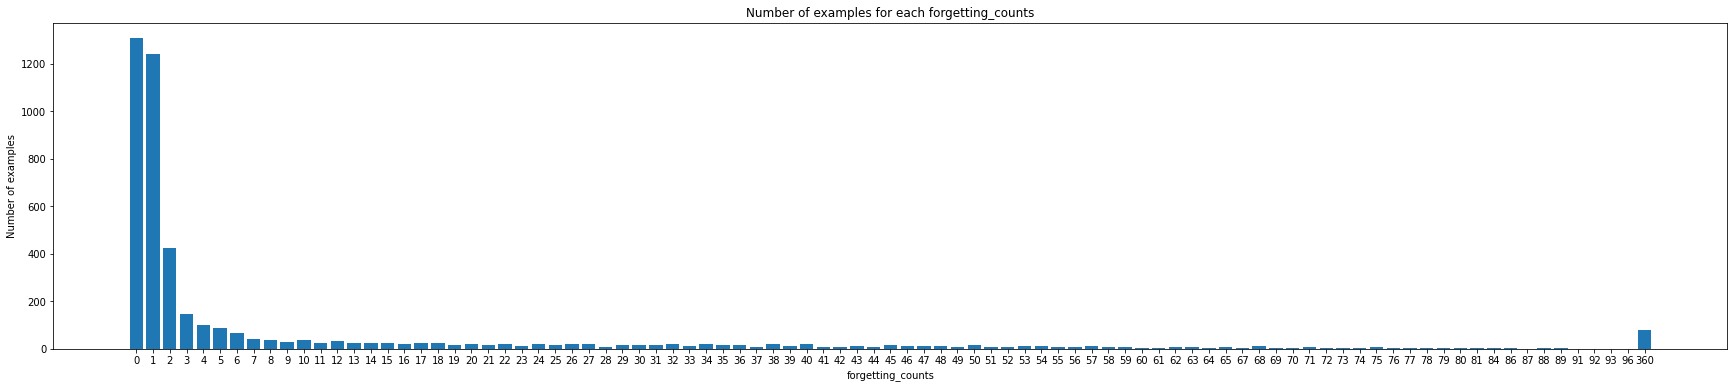

In [8]:
series_for_plot = df_examples_forgetting_info.groupby(by='forgetting_counts')['example_idx'].count()

plt.figure(figsize=(30, 6))
x_axis = [str(item) for item in series_for_plot.index]
y_axis = series_for_plot.values
plt.bar(x_axis, y_axis)
plt.title('Number of examples for each forgetting_counts')
plt.xlabel('forgetting_counts')
plt.ylabel('Number of examples')
plt.show()

#### 3.2 Training the model on the filtered dataset

Since we have found examples with noisy labels, we can exclude them from the original dataset to improve model training.

In [13]:
log_dir = '../data/rosbank/logs'
ckpt_dir = '../data/rosbank/ckpts'

path_to_dataconf = '../srcprcskr/configs/data/data_config_rosbank_demonstration.yml'
path_to_modelconf = '../srcprcskr/configs/models/model_config_rosbank_demonstration.yml'

run_name = 'rosbank_notebook_after_forgetting'

classifier = FilteredClassifier(
    run_name = run_name,
    log_dir=log_dir, 
    ckpt_dir=ckpt_dir,
    path_to_dataconf=path_to_dataconf,
    path_to_modelconf=path_to_modelconf
)

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'

split_frac_train_val = 0.9

path_to_examples_to_be_excluded= '../data/rosbank/rosbank_dataset/train_part/rosbank_forgetting/rosbank_examples_to_be_excluded.txt'

classifier.fit(
    features_path=features_path,
    targets_path=targets_path,
    split_frac_train_val=split_frac_train_val,
    path_to_examples_to_be_excluded=path_to_examples_to_be_excluded
)

```
Metrics for the validation dataset:
{'acc_score': 0.6583710407239819, 'recall_score': 0.5357142857142857, 'roc_auc_score': 0.6639294403892944, 'pr_auc_score': 0.5989475236182171}
```

In [16]:
features_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_targets.parquet'
ckpt_resume = '../data/rosbank/ckpts/rosbank_notebook_after_forgetting_fit/epoch: 0097 - acc_score: 0.6878 - recall_score: 0.494 - roc_auc_score: 0.6794 - pr_auc_score: 0.6467 - loss: 0.5258.ckpt'
preds_proba, uncertainties, file_names, true_labels = classifier.predict(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10


100%|██████████| 4/4 [00:00<00:00,  9.83it/s]


In [17]:
preds_labels = np.argmax(preds_proba, axis=1)
preds_proba_pos = np.max(preds_proba, axis=1)

acc_eval = accuracy_score(true_labels, preds_labels)
recall_eval = recall_score(true_labels, preds_labels)
rocauc_eval = roc_auc_score(true_labels, preds_proba_pos)

precision_eval, recall_evall, _ = precision_recall_curve(true_labels, preds_proba_pos)
pr_recall_auc = auc(recall_evall, precision_eval)

print(f'acc: {acc_eval:.3f}, recall: {recall_eval:.3f}, roc_auc: {rocauc_eval:.3f}, precision_recall {pr_recall_auc:.3f}')

acc: 0.700, recall: 0.710, roc_auc: 0.655, precision_recall 0.779


We can see that the metrics are slightly improved in comparison with the previous section, when the filtration was not applied.

#### 3.3 Training the model on the dataset with corrected labels

In the previous case we exclude examples with noisy labels. But we also can change labels of the examples to the opposite.

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets_corrected_by_forgetting.parquet'

split_frac_train_val = 0.9

path_to_examples_to_be_excluded= None

classifier.fit(
    features_path=features_path,
    targets_path=targets_path,
    split_frac_train_val=split_frac_train_val,
    path_to_examples_to_be_excluded=path_to_examples_to_be_excluded
)

```
Metrics for the validation dataset:
{'acc_score': 0.6755555555555556, 'recall_score': 0.49707602339181284, 'roc_auc_score': 0.6766018990127649, 'pr_auc_score': 0.6263341126360764}
```

In [19]:
features_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_targets.parquet'
ckpt_resume = '../data/rosbank/ckpts/rosbank_notebook_after_forgetting_fit/epoch: 0286 - acc_score: 0.6822 - recall_score: 0.4737 - roc_auc_score: 0.6853 - pr_auc_score: 0.6439 - loss: 0.4612.ckpt'
preds_proba, uncertainties, file_names, true_labels = classifier.predict(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10


100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


In [20]:
preds_labels = np.argmax(preds_proba, axis=1)
preds_proba_pos = np.max(preds_proba, axis=1)

acc_eval = accuracy_score(true_labels, preds_labels)
recall_eval = recall_score(true_labels, preds_labels)
rocauc_eval = roc_auc_score(true_labels, preds_proba_pos)

precision_eval, recall_evall, _ = precision_recall_curve(true_labels, preds_proba_pos)
pr_recall_auc = auc(recall_evall, precision_eval)

print(f'acc: {acc_eval:.3f}, recall: {recall_eval:.3f}, roc_auc: {rocauc_eval:.3f}, precision_recall {pr_recall_auc:.3f}')

acc: 0.686, recall: 0.693, roc_auc: 0.629, precision_recall 0.755


Training with corrected labels does not lead to metrics improvement.

### 4. Filtration the dataset through the second split forgetting method

#### 4.1 Search examples for excluding

To find the examples, which are forever forgotten as model training is continued, the `filtration_by_second_forgetting` method is applied.
The method includes 4 steps. In the first step, the model is trained on the first half part of the dataset. In the second step, the train of the model is continued on the second part of the dataset. The examples forgotten after one epoch of the second step are marked as noisy. Then the model is trained on the second half part of the dataset from the beggining. In the fourth step, the examples forgotten after one epoch of the model training on the first half of the dataset are marked as noisy. All noisy examples are united and written in in a `.txt` file. Also, the method returns `pd.DataFrame`, which contains epochs when an examples was forggoten forever at the second and fourh steps, as well as the predictions given by the trained model for these steps.

In [21]:
log_dir = '../data/rosbank/logs'
ckpt_dir = '../data/rosbank/ckpts'

path_to_dataconf = '../srcprcskr/configs/data/data_config_rosbank_demonstration.yml'
path_to_modelconf = '../srcprcskr/configs/models/model_config_rosbank_demonstration.yml'

run_name = 'rosbank_notebook'

classifier = FilteredClassifier(
    run_name = run_name,
    log_dir=log_dir, 
    ckpt_dir=ckpt_dir,
    path_to_dataconf=path_to_dataconf,
    path_to_modelconf=path_to_modelconf
)

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'
df_examples_secondforgetting_info = classifier.filtration_by_second_split_forgetting(
    features_path=features_path,
    targets_path=targets_path
)

```
Number of examples to exclude: 382
Examples forgetting stats are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_secondsplit_forgetting/rosbank_secondsplit_forgetting_stats.csv
Examples for excluding are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_secondsplit_forgetting/rosbank_examples_to_be_excluded.txt
Corrected labels are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_targets_corrected_by_secondsplit_forgetting.parquet
```

DataFrame df_examples_secondforgetting_info includes the following columns: <br>
$\quad$ - <b> example_idx </b> is an index of an example in the dataset. <br>
$\quad$ - <b> example_name </b> is name of a file containing an examlpe <br>
$\quad$ - <b> pred_proba </b> is the max probability which predicted by the model for an example<br>
$\quad$ - <b> uncertainty </b> of a model prediction for an example <br>
$\quad$ - <b> pred_label </b> is a label which predicted the model for an example <br>
$\quad$ - <b> true_label </b> of an example in the dataset <br>
$\quad$ - <b> epoch_forget_forever </b> is the number of an epoch when an example was forgotten forever <br>
$\quad$ - <b> is_filtered </b> is an indicator which is equal to 1 if an example should be excluded and 0 in the other case <br>
$\quad$ - <b> corrected_label </b> is a label of an example after label correction <br>

In [23]:
df_examples_secondforgetting_info

,example_idx,example_name,pred_proba,uncertainty,pred_label,true_label,epoch_forget_forever,is_filtered,corrected_label
0,0,0,0.298667,0.609730,0,0,361,0,0
1,1,1,0.052969,0.207166,0,0,361,0,0
2,2,10,0.097542,0.319649,0,0,361,0,0
3,3,10001,0.199534,0.499756,0,0,361,0,0
4,4,10004,0.051283,0.202277,0,0,361,0,0
...,...,...,...,...,...,...,...,...,...
4495,2245,9989,0.921199,0.275832,1,1,361,0,1
4496,2246,9991,0.709318,0.602762,1,1,361,0,1
4497,2247,9992,0.182403,0.475018,0,0,361,0,0
4498,2248,9995,0.381719,0.664899,0,0,361,0,0


Using this dataframe we can count a quantity of examples with the same <b>epoch_forget_forever</b> and calculate mean uncertainty among examples with the same <b>epoch_forget_forever</b>.

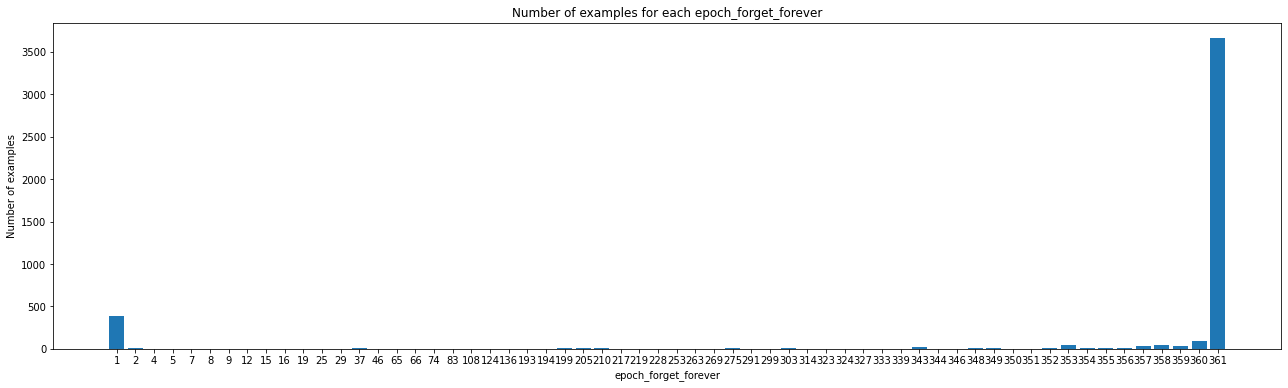

In [24]:
series_for_plot = df_examples_secondforgetting_info.groupby(by='epoch_forget_forever')['example_idx'].count()

plt.figure(figsize=(22, 6))
x_axis = [str(item) for item in series_for_plot.index]
y_axis = series_for_plot.values
plt.bar(x_axis, y_axis)
plt.title('Number of examples for each epoch_forget_forever')
plt.xlabel('epoch_forget_forever')
plt.ylabel('Number of examples')
plt.show()

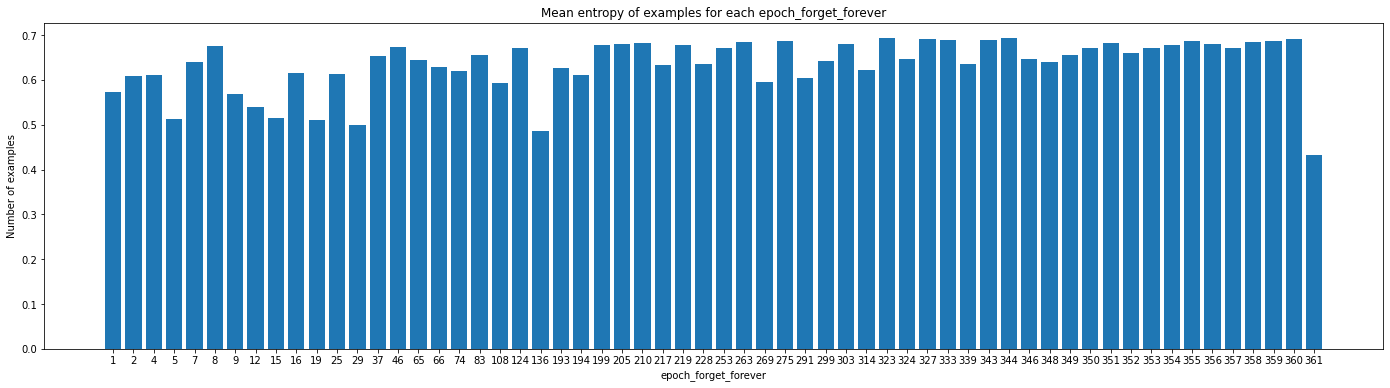

In [25]:
series_for_plot = df_examples_secondforgetting_info.groupby(by='epoch_forget_forever')['uncertainty'].mean()

plt.figure(figsize=(24, 6))
x_axis = [str(item) for item in series_for_plot.index]
y_axis = series_for_plot.values
plt.bar(x_axis, y_axis)
plt.title('Mean entropy of examples for each epoch_forget_forever')
plt.xlabel('epoch_forget_forever')
plt.ylabel('Number of examples')
plt.show()

As in the previous section, we can load masks for computting forgetting values from a `*.ckpt` file.

In [12]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'
ckpt_resume = '/home/storage/priceseekers/data/rosbank/ckpts/rosbank_notebook_second_forgetting/second_forgetting_step4/epoch: 0100 - acc_score: 0.7129 - roc_auc_score: 0.7795 - pr_auc_score: 0.8804 - loss: 0.572.ckpt'

df_examples_secondforgetting_info = classifier.filtration_by_second_split_forgetting(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10
total epochs is specified from config as 50
lr is specified from config as 0.0005


100%|██████████| 18/18 [00:00<00:00, 31.56it/s]


Number of examples to exclude: 44
Examples forgetting stats are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_second_forgetting/rosbank_second_forgetting_stats.csv
Examples for excluding are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_second_forgetting/rosbank_examples_to_be_excluded.txt
Corrected labels are saved in ../data/rosbank/rosbank_dataset/train_part/rosbank_targets_corrected_by_secondsplit_forgetting.parquet


/opt/conda/lib/python3.7/site-packages/prcskr/data_loaders/datautils.py:23: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  pa_tab = pa.Table.from_pandas(df)


#### 4.2 Training the model on the filtered dataset

After we have found examples with noisy labels, we can train model on the filtered dataset. 

In [26]:
log_dir = '../data/rosbank/logs'
ckpt_dir = '../data/rosbank/ckpts'

path_to_dataconf = '../srcprcskr/configs/data/data_config_rosbank_demonstration.yml'
path_to_modelconf = '../srcprcskr/configs/models/model_config_rosbank_demonstration.yml'

run_name = 'rosbank_notebook_after_secondsplitforgetting'

classifier = FilteredClassifier(
    run_name = run_name,
    log_dir=log_dir, 
    ckpt_dir=ckpt_dir,
    path_to_dataconf=path_to_dataconf,
    path_to_modelconf=path_to_modelconf
)

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets.parquet'
split_frac_train_val = 0.9
path_examples_to_be_excluded = '../data/rosbank/rosbank_dataset/train_part/rosbank_secondsplit_forgetting/rosbank_examples_to_be_excluded.txt'
classifier.fit(
    features_path=features_path,
    targets_path=targets_path,
    split_frac_train_val=split_frac_train_val,
    path_to_examples_to_be_excluded=path_examples_to_be_excluded
)

```
Metrics for the validation dataset:
{'acc_score': 0.7281553398058253, 'recall_score': 0.6176470588235294, 'roc_auc_score': 0.7639599317988065, 'pr_auc_score': 0.6639197991399316}
```

In [28]:
features_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_targets.parquet'
ckpt_resume = '../data/rosbank/ckpts/rosbank_notebook_after_secondsplitforgetting_fit/epoch: 0158 - acc_score: 0.7306 - recall_score: 0.6103 - roc_auc_score: 0.7435 - pr_auc_score: 0.6777 - loss: 0.4326.ckpt'
preds_proba, uncertainties, file_names, true_labels = classifier.predict(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


In [29]:
preds_labels = np.argmax(preds_proba, axis=1)
preds_proba_pos = np.max(preds_proba, axis=1)

acc_eval = accuracy_score(true_labels, preds_labels)
recall_eval = recall_score(true_labels, preds_labels)
rocauc_eval = roc_auc_score(true_labels, preds_proba_pos)

precision_eval, recall_evall, _ = precision_recall_curve(true_labels, preds_proba_pos)
pr_recall_auc = auc(recall_evall, precision_eval)

print(f'acc: {acc_eval:.3f}, recall: {recall_eval:.3f}, roc_auc: {rocauc_eval:.3f}, precision_recall {pr_recall_auc:.3f}')

acc: 0.710, recall: 0.720, roc_auc: 0.648, precision_recall 0.770


We can see, that excluding examples according to the second split frogetting method leads to a signigicant incearse in metrics on the test dataset compared to the metrics obrained after filtration with the forgetting method.

#### 4.3 Training the model on the dataset with corrected labels

In [ ]:
features_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/train_part/rosbank_targets_corrected_by_secondsplit_forgetting.parquet'
split_frac_train_val = 0.9
path_examples_to_be_excluded = None
classifier.fit(
    features_path=features_path,
    targets_path=targets_path,
    split_frac_train_val=split_frac_train_val,
    path_to_examples_to_be_excluded=path_examples_to_be_excluded
)

```
Metrics for the validation dataset:
{'acc_score': 0.7444444444444445, 'recall_score': 0.5923566878980892, 'roc_auc_score': 0.7783961218234386, 'pr_auc_score': 0.6854811419810235}
```

In [31]:
features_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_pca_embeddings.parquet'
targets_path = '../data/rosbank/rosbank_dataset/test_part/rosbank_targets.parquet'
ckpt_resume = '../data/rosbank/ckpts/rosbank_notebook_after_secondsplitforgetting_fit/epoch: 0191 - acc_score: 0.7311 - recall_score: 0.6624 - roc_auc_score: 0.7799 - pr_auc_score: 0.7084 - loss: 0.3875.ckpt'
preds_proba, uncertainties, file_names, true_labels = classifier.predict(
    features_path=features_path,
    targets_path=targets_path,
    ckpt_resume=ckpt_resume
)

random state is specified from config as 10


100%|██████████| 4/4 [00:00<00:00, 12.70it/s]


In [32]:
preds_labels = np.argmax(preds_proba, axis=1)
preds_proba_pos = np.max(preds_proba, axis=1)

acc_eval = accuracy_score(true_labels, preds_labels)
recall_eval = recall_score(true_labels, preds_labels)
rocauc_eval = roc_auc_score(true_labels, preds_proba_pos)

precision_eval, recall_evall, _ = precision_recall_curve(true_labels, preds_proba_pos)
pr_recall_auc = auc(recall_evall, precision_eval)

print(f'acc: {acc_eval:.3f}, recall: {recall_eval:.3f}, roc_auc: {rocauc_eval:.3f}, precision_recall {pr_recall_auc:.3f}')

acc: 0.710, recall: 0.758, roc_auc: 0.667, precision_recall 0.771


In this case training model on the dataset with corrected labels leads to an increase of the metrics.